# Quantum computing hands-on

This notebook presentation is part of the series of lecutures on the basics of quantum computing of the CERN Openlab Summer Student Programme 2024. It contains a general introduction to the Pennylane software platform with guided excercises.

**Giulio Crognaletti**, PhD student @ University of Trieste

## Hands-on with Pennylane

#### Why Pennylane?

Many of you may be wondering why Pennylane? Isn't Qiskit the most common Quantum SDK? Why bother learning a new one?

While it is true that Qiskit is a very popular and very good quantum software toolkit, there are some peculiar advantages that a platform like Pennylane has over Qiskit. As an example, it is higly optimized for parameterized circuits, as it integrates *automatic differentiation* capabilities to the quantum simulators, making it a lot faster when it comes to Quantum Machine Learning (QML) applications!

While in this lecture we won't get into QML, it's still useful to know the basics of the framework, as it can be used for a wide variety of quantum applications, including more standard quantum algorithms. The most valuable source of information in this regard is of course the official API guide (https://docs.pennylane.ai/en/stable/code/qml.html), which contains documentation, tutorials and more.

In this lecture, we'll go through the main concepts, necessary to succesfully build and execute a simple circuit. In particular we will learn about:

* quantum functions (i.e. circuits)
* observables
* devices and quantum nodes

Let's get started!

#### First steps

The first step is to install and import the pennylane package. The standard import is `qml`.

Since it will be useful to use numpy primitives and functions throught the tutorial, we will import numpy as well. Note however that is **crucial** to import numpy directly *from* pennylane. This is important to make sure that automatic differentiation works properly.

In [1]:
# Install Pennylane
#!pip install pennylane

# Import it
import pennylane as qml
from pennylane import numpy as np

In [2]:
qml.__version__

'0.37.0'

#### Circuits vs quantum functions

In most quantum SDKs there are dedicated primitives that implement *Quantum circuits*. If you already have some experience with quantum computing, you may recall that indeed, this was the case for IBM's Qiskit, where quantum algorithms are realized as specific circuit objects:

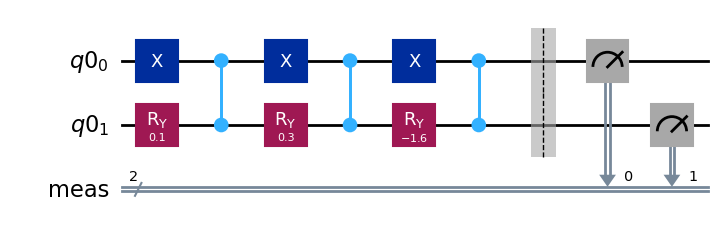

In [3]:
from qiskit import QuantumCircuit, QuantumRegister

theta_value = np.array([0.1, 0.3, -1.6], requires_grad=True)

qr = QuantumRegister(2)
qiskit_circ = QuantumCircuit(qr)

for t in theta_value:
    qiskit_circ.x(qr[0])
    qiskit_circ.ry(t.item(), qr[1])
    qiskit_circ.cz(qr[0], qr[1])

qiskit_circ.measure_all()

qiskit_circ.draw("mpl")

While this approach is straight-forward to understand, this makes handling some situations more cumbersome than really needed. Take for instance the case of a circuit whose gates, depend on some parameter $\theta$. What if I want to change the numerical value of $\theta$? This would either require the creation of a new circuit, or usage of more complicated abstractions, which can make our code hard to develop.  

At the end of the day, quantum circuits are a kind of function, that map some intitial state to the final state, so why not use this and implement a *quantum function*?

This is Pennylane's strategy, where circuits are represented by special kinds of **functions**, which are called quantum functions. In particular, each parameterized circuit $U(\cdot)$ is represented by a function the acts on parameter space $\Theta = [-\pi,\pi]^{p}$ and returns the circuit output, which in general is a collection of expectation values of observables $\{O_i\}_{i=1}^n$.

$$f_{U, \psi_0} : \Theta \to \mathbb {R}^n$$
$$ \theta \in \Theta \to \left[\langle \psi_0 |U^\dagger (\theta) O_1 U(\theta)|\psi_0\rangle, ... , \langle \psi_0 |U^\dagger (\theta) O_n U(\theta)|\psi_0\rangle\right] \in \mathbb {R}^n$$

This framework can be generalized to include also other types of circuit outputs, for instance computational basis measurements, or the quantum statevector itself (for simulations), and of course a **non paramterized** circuit is still a function, but with no inputs. 

In pennylane, quantum functions are implemented simply as Python functions, and evaluation of quantum functions are linked to the estimation of the circuit output specified during the definition.

Writing a quantum function is as simple as this:

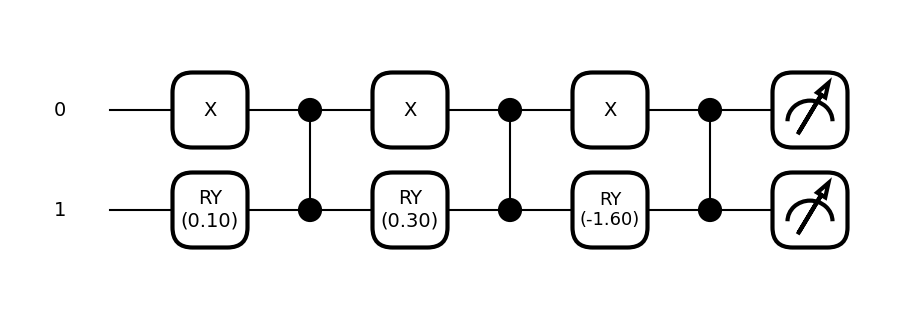

In [4]:
# The parameters of the circuit are specified as the input of the function
def circ_fn(theta):

    #By default, the initial state is |0>, just as in Qiskit

    # Gates, operations, or even other quantum functions called here will be part of circ
    # Cycles and other control flow structures are allowed, as long as they do not depend 
    # on the value of the parameters
    for t in theta:
        qml.PauliX(0)
        qml.RY(t, 1)
        qml.CZ([0,1])

    # The output type is defined with the return statement. In this case computational basis measurement is specified.
    return qml.probs()

_ = qml.draw_mpl(circ_fn, decimals=2)(theta_value)

Pennylane offers a wide variety of gates, which you can discover at https://docs.pennylane.ai/en/stable/code/qml.html#classes

Moreover, in pennylane, quantum functions are always *differentiable*, and gradients of quantum functions can be computed by a wide variety of methods. 

#### E.1

Create and display a quantum fuction for a circuit that includes at least a CNOT, one Hadamard gates and one X gate, and return the marginal probabilities for each qubit.

(*Hint*: The marginal proability of a qubit can be obtain by specifying it to `qml.probs`, i.e. `qml.probs(0)` represents the marginal probability of the zeroth quit)

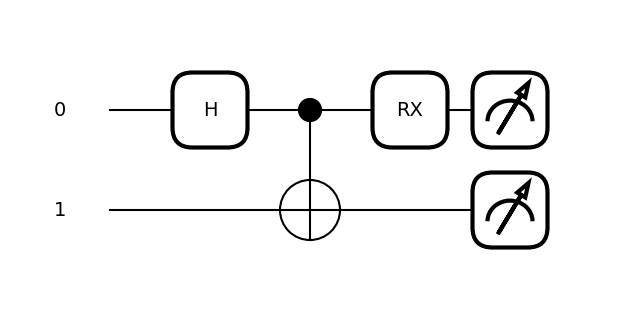

In [5]:
dev = qml.device("default.qubit", wires=2)

# Define quantum function
@qml.qnode(dev)
def bell_state():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RX(np.pi / 4, wires=0)
    return qml.probs(wires=[0, 1])

_ = qml.draw_mpl(bell_state)()

#### Observables

Once we have formulated our very cool quantum algorithm, which elegantly encodes the problem in the quantum system, we might face the dilemma of how *to extract* the information provided by the quantum computation. Of course, we generally **do not** have access to the full state of the system, so we have to be smart about it.

Generally, we need to devise a strategy that will allow us to know only the interesting properties of the state, i.e. measure some **observable**.

In quantum theory, an observable is defined as an operator $O=O^\dagger$ acting on the system's Hilbert space $\mathcal{H}$. Due to the exponential dimension of $\mathcal{H}$ ($\text{dim}(\mathcal{H})=2^q$), describing $O$ is in general quite demanding. 

However, for simple enough observables, there exist very compact descriptions that can be used to define it:

* **Pauli decomposition**: It is common to define observables as linear combination of tensor produts of Pauli operators $\sigma_k$ acting on single qubits. This is especially true for Hamiltonians, that often take the form $$ H = \sum_i c_i P_i \;\;\; \text{where} \;\;\;\; P_i = \bigotimes_k \sigma^{(k)}_{i_k}$$
(In fact, every operator acting on a quantum register can  be decomposed in this way, but this strategy can incurr in exponential number of terms to keep track.)

* **Hermitian matrix**: Given a basis, each observable is represented by a Hermitian matrix, which fully characterizes $O$. However this type of description is suited only for small sistems, i.e. few qubits.

Pennylane allows to use both descriptions to characterize an observable. As an example, let's  implement
$$O = 1.7 X^{(0)}\otimes Y^{(1)} - 0.2 Z^{(0)}\otimes Z^{(1)}$$

In [6]:
# Pauli decomposition

# First we need to define the list of coefficients of the linear combination
cs = [1.7, -0.2]

# Then we need to implement the pauli strings
# @ indicates the tensor products
os = [qml.PauliX(0)@qml.PauliY(1), qml.PauliZ(0)@qml.PauliZ(1)]

O_ham = qml.Hamiltonian(cs, os)

# Hermitian matrix

O_mat = [[0.2,0,0,-1.7j],
         [0,-0.2,1.7j,0],
         [0,-1.7j,-0.2,0],
         [1.7j,0,0,0.2]]

O_her = qml.Hermitian(O_mat, wires=(0,1)) #Note: qubits in Pennylane are called "quantum wires"

Both of them can be used as the output of a quantum function, which means that the information extracted from running the circuit, will be automatically used to compute the expectation values of those observable!

In [7]:
def obs_circ_fn(theta):

    for t in theta:
        qml.PauliX(0)
        qml.RY(t, 1)
        qml.CZ([0,1])
        
    return qml.expval(O_ham)

Note that, computational basis measurements are also measurements of this kind. In that case we need $q$ observables, one per qubit, each of which is represented by the Pauli $Z$ operator.

#### E.2

Build the 4 qubit observable:

$$O = 0.25*Z \otimes 1\!\!1  \otimes 1\!\!1 \otimes 1\!\!1 +  0.25*1\!\!1 \otimes Z \otimes 1\!\!1 \otimes 1\!\!1 + 0.25*1\!\!1 \otimes 1\!\!1 \otimes Z \otimes 1\!\!1  + 0.25* 1\!\!1  \otimes 1\!\!1 \otimes 1\!\!1 \otimes Z$$

In [8]:
# Live demo
dev = qml.device("default.qubit", wires=5)

# define observables
coeffs = [0.4, 0.1, 0.25, 0.15, 0.05]
obs = [qml.PauliZ(i) for i in range(5)]
H = qml.Hamiltonian(coeffs, obs)

# Define the quantum circuit
@qml.qnode(dev)
def circuit():
    # Apply some quantum gates (this is just an example)
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RX(np.pi / 4, wires=2)
    qml.RY(np.pi / 3, wires=3)
    qml.RZ(np.pi / 2, wires=4)
    return qml.expval(H)

result = circuit()
print(result)

0.3017766952966368


#### Devices and Quantum Nodes

Quantum functions alone, just as quantum circuits, are only an abstract description of the quantum algorithm, and are not enough to acutally perform computations. For that, we need *devices*.

In pennylane, a device represents an entity able to execute quantum functions, be it a simulator or a real quantum device.

Thanks to the large amout of interfaces and plugins that this environment provides (https://pennylane.ai/plugins/) code written in pennylane can run almost on all quantum simulator (ideal, noisy, tensor-network based etc..) and even real devices (including IBM public machines!). Of course, each device has its own peculiarity and must be configured with care. 

Today we'll focus on the simplest one, i.e. `deafult.qubit`.

In [9]:
# Each device is created by calling qml.device, and specifying its device name, toghether with all required properties

dev = qml.device("default.qubit", wires=2, shots=None) # If no shots are specified, the simulation will be exact 

In order to run, the device and the quantum function must be joined to form a so called "Quantum Node" or "QNode". QNodes are the most important objects in Pennylane, since they are responsible of handling *execution* and possibly *differentiation* of quantum functions.

In [10]:
obs_qnode = qml.QNode(obs_circ_fn, dev)

# Finally execute the function
obs_qnode(theta_value)

tensor(0.03399343, requires_grad=True)

Since the concept of qnode and quantum function are so close to each other, and often one needs to create both at the same time, Pennylane offers a quick way of doing so, using the `qml.qnode` *decorator*.

In [11]:
@qml.qnode(dev, interface="autograd", diff_method="backprop")
def decorated_qfun(theta):

    for t in theta:
        qml.PauliX(0)
        qml.RY(t, 1)
        qml.CZ([0,1])
        
    return qml.expval(O_ham)

decorated_qfun(theta_value)

tensor(0.03399343, requires_grad=True)

#### Preparing the GHZ state and measure it

As an example of the above, let us prepare the GHZ state and measure the expectation value of the observable in E.2.

What is a GHZ state?

This one:
$$|GHZ\rangle = \frac{|000...0\rangle + |111...1\rangle}{\sqrt{2}}$$

Why the GHZ? 

Well, because it is, in a sense, a quantum state that is *very quantum* compared to other classes of states. In fact it exhibits a large degree of entanglement (by many, but crucially not all measures), and has interesting properties related to non-locality. In general it is a good starting point to explore quantum computing.

How can we prepare it? What information can we get out of it?

First, we need to fix the number of qubits. Here we will work with 4. Then we look at the circuit we need to implement:

![image](ghz.ppm)

For the rest, we let the code talk!

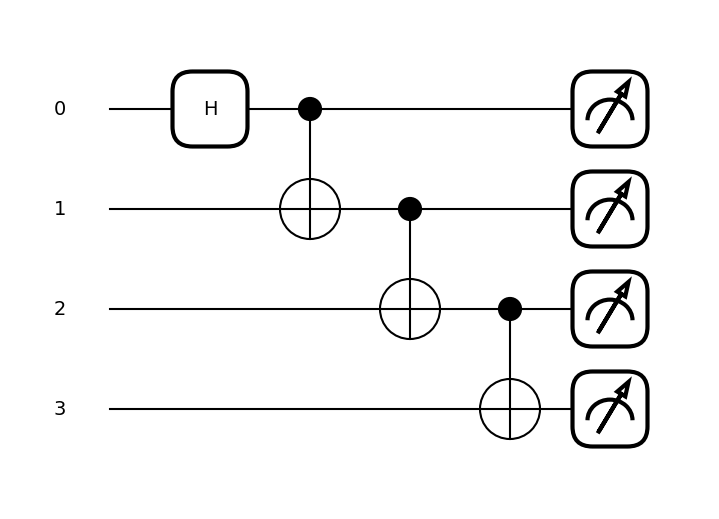

In [27]:
# Live demo

#Number of qubits (or "quantum wires")
W = 4 

#Steps:
# 1) Define the appropriate quantum function
dev = qml.device("default.qubit", W)

# Define the quantum function to create the GHZ state
@qml.qnode(dev)
def ghz():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    return qml.state()

_ = qml.draw_mpl(ghz)()

In [28]:
# 2) Define the observable
coeffs = [0.4, 0.1, 0.25, 0.15, 0.05]
obs = [qml.PauliZ(i) for i in range(4)]
H = qml.Hamiltonian(coeffs[:len(obs)], obs)

In [29]:
# 3) Build a QNode

#Specify the device
@qml.qnode(dev)
#Build the qnode
def measure_ghz():
    ghz()
    return qml.expval(H)

In [30]:
# 4) Execute the quantum function
result = measure_ghz()
print(result)

0.9
